In [ ]:
import torch
from torch import nn
from torchvision import datasets
from torchvision.transforms import ToTensor

In [ ]:
train_data = datasets.CIFAR10(root="data",
                              train=True,
                              transform=ToTensor(),
                              download=True)

val_data = datasets.CIFAR10(root="data",
                            train=False,
                            transform=ToTensor(),
                            download=True)

100%|██████████| 170M/170M [00:05<00:00, 31.0MB/s]


Extracting data/cifar-10-python.tar.gz to data
Files already downloaded and verified


In [ ]:
len(train_data), len(val_data)

(50000, 10000)

In [ ]:
classes = train_data.classes

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
image, label = train_data[20]

(-0.5, 31.5, 31.5, -0.5)

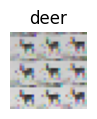

In [ ]:
plt.figure(figsize=(1, 1))
plt.imshow(image.reshape(32, 32, 3))
plt.title(classes[label])
plt.axis(False)

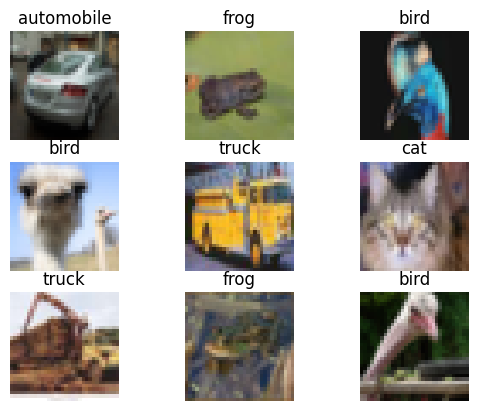

In [ ]:
fig, axis = plt.subplots(3, 3)
for i in range(9):
  random_idx = torch.randint(0, len(train_data), size=[1])
  axis[i//3, i%3].imshow(train_data[random_idx][0].permute(1, 2, 0))
  axis[i//3, i%3].set_title(classes[train_data[random_idx][1]])
  axis[i//3, i%3].axis(False)

In [ ]:
from torch.utils.data.dataloader import DataLoader

In [ ]:
train_dataloader = DataLoader(train_data,
                              batch_size=32,
                              shuffle=True)
val_dataloader = DataLoader(val_data,
                            batch_size=32)

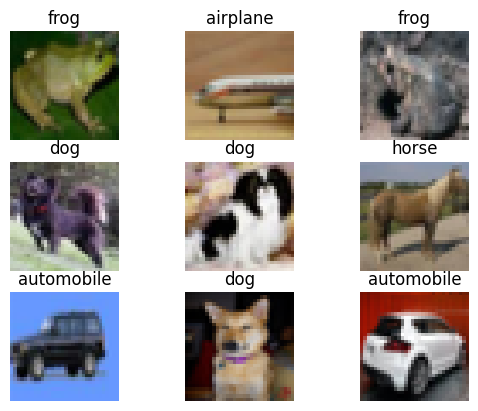

In [ ]:
batch_images, batch_labels = next(iter(train_dataloader))
fig, axis = plt.subplots(3, 3)
for i in range(9):
  axis[i//3, i%3].imshow(batch_images[i].permute(1, 2, 0))
  axis[i//3, i%3].set_title(classes[batch_labels[i]])
  axis[i//3, i%3].axis(False)

In [ ]:
class AlexNet(nn.Module):
  def __init__(self,
               input_shape,
               output_shape):
    super().__init__()
    self.conv1 = nn.Conv2d(in_channels=input_shape,
                            out_channels=96,
                            stride=2,
                            kernel_size=3,
                           padding=1)
    self.max_pool1 = nn.MaxPool2d(2)
    self.relu1 = nn.ReLU()

    self.conv2 = nn.Conv2d(in_channels=96,
                            out_channels=256,
                            stride=2,
                            kernel_size=3,
                           padding=1)
    self.max_pool2 = nn.MaxPool2d(2)
    self.relu2 = nn.ReLU()

    self.conv3 = nn.Conv2d(in_channels=256,
                            out_channels=384,
                            stride=2,
                            kernel_size=3)
    self.conv4 = nn.Conv2d(in_channels=384,
                            out_channels=384,
                            stride=2,
                            kernel_size=3)
    self.conv5 = nn.Conv2d(in_channels=256,
                            out_channels=256,
                            stride=2,
                            kernel_size=3)

    self.relu5 = nn.ReLU()
    self.max_pool5 = nn.MaxPool2d(2)

    self.flatten = nn.Flatten()
    self.fc1 = nn.Linear(in_features=256*2*2,
                          out_features=4096)
    self.relu_fc1 = nn.ReLU()
    self.fc2 = nn.Linear(in_features=4096,
                          out_features=4096)
    self.relu_fc2 = nn.ReLU()
    self.fc3 = nn.Linear(in_features=4096,
                          out_features=output_shape)

  def forward(self, x):
    x = self.conv1(x)
    x = self.max_pool1(x)
    x = self.relu1(x)
    x = self.conv2(x)
    x = self.max_pool2(x)
    x = self.relu2(x)
    # x = self.conv3(x)
    # print(x.shape)
    # x = self.conv4(x)
    # print(x.shape)
    # x = self.conv5(x)
    # print(x.shape)
    # x = self.max_pool5(x)
    # x = self.relu5(x)
    x = self.flatten(x)
    x = self.fc1(x)
    x = self.relu_fc1(x)
    x = self.fc2(x)
    x = self.relu_fc2(x)
    return self.fc3(x)



In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [ ]:
model = AlexNet(input_shape=3,
                output_shape=10).to(device)

In [ ]:
logits = model(batch_images.to(device))
logits.shape

torch.Size([32, 10])

In [ ]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=model.parameters(),
                            lr=0.001)

In [ ]:
epochs = 10
train_losses = []
val_losses = []
for epoch in range(epochs):
  train_loss, val_loss = 0, 0
  model.train()
  for X, y in train_dataloader:
    X, y = X.to(device), y.to(device)
    y_pred = model(X)
    loss = loss_fn(y_pred, y)
    train_loss += loss

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
  train_loss /= len(train_dataloader)
  with torch.inference_mode():
    model.eval()
    for X, y in val_dataloader:
      X, y = X.to(device), y.to(device)
      y_pred = model(X)
      loss = loss_fn(y_pred, y)
      val_loss += loss
      val_loss /= len(val_dataloader)
  train_losses.append(train_loss)
  val_losses.append(val_loss)
  print(f"epoch{epoch+1}: train_loss={train_loss:.4f}--val_loss={val_loss:.4f}")


epoch1: train_loss=0.0063--val_loss=0.0033
epoch2: train_loss=0.0055--val_loss=0.0034
epoch3: train_loss=0.0050--val_loss=0.0035
epoch4: train_loss=0.0047--val_loss=0.0035
epoch5: train_loss=0.0045--val_loss=0.0035
epoch6: train_loss=0.0042--val_loss=0.0035


In [ ]:
len(classes)

10

In [ ]:
for i in range(len(train_losses)):
  train_losses[i] = train_losses[i].detach().numpy()


In [ ]:
for i in range(len(val_losses)):
  val_losses[i] = val_losses[i].cpu().detach().numpy()

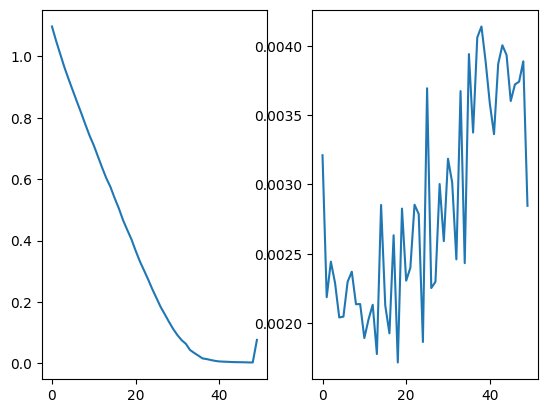

In [ ]:
fig, ax = plt.subplots(1, 2)
ax[0].plot(train_losses)
ax[1].plot(val_losses)